In [1]:
import os #os.makedirs

import numpy as np

In [2]:
import yt
#yt.enable_parallelism()

yt.set_log_level(50)

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

In [4]:
mpl.rcParams["figure.facecolor"]="white"

## Make some derived fields for yt 

In [5]:
def _cold_mass_temp_x(field, data,temp_thresh):
    temp = data['temperature']
    mass = data['density'] * data['cell_volume']
    ind = np.where(temp > temp_thresh)
    mass[ind] = 0.0
    return mass


In [6]:
cold_mass_temp_threshs = (1e4,1e5,4e7,np.inf)
cold_mass_full_names = [ ("gas", f"cold_mass_temp_{temp_thresh:.1e}") 
                        for temp_thresh in cold_mass_temp_threshs ]

In [7]:

for temp_thresh,full_name in zip(cold_mass_temp_threshs,cold_mass_full_names):
    function=lambda field,data,temp_thresh=temp_thresh: \
        _cold_mass_temp_x(field,data,temp_thresh)
    function.__name__ = full_name[1]

    yt.add_field(full_name, 
        function= function,
        sampling_type="local",
        units='Msun')


## Define and set specifications for slice data and slice plots

In [8]:
#fields = ["density","mach_number","temperature"]
#field_units = {"density":"g/cm**3","temperature":"K"}

#fields = ["magnetic_field_x","magnetic_field_y","magnetic_field_z","magnetic_energy_density"]
#fields = ["density","pressure","temperature","mach_number","cooling_time","cooling_rate",
#          "magnetic_field_x","magnetic_field_y","magnetic_field_z",
#          "magnetic_energy_density"]


class SliceDataSpec:
    """
    SliceDataSpec
    
    Class for slice data specifications
    """
    def __init__(self,
                 fields, #Fields to save to disk
                 axis,
                 coord,
                 width,
                 resolution,
                 center=(0,0,0),
                 height=None,  
                 ):
        self.fields = fields
        self.axis = axis
        self.coord = coord
        self.width = width
        self.resolution = resolution
        self.center = center
        self.height = height
        
        cart_axes = ["x","y","z"]  
        self.axis_1 = cart_axes[(cart_axes.index(axis)+1)%3]
        self.axis_2 = cart_axes[(cart_axes.index(axis)+2)%3]

    def __eq__(self, other):
       
        # Equality Comparison between two objects
        return np.all([self.fields == other.fields,
                       self.axis == other.axis,
                       self.coord == other.coord,
                       self.width == other.width,
                       self.resolution == other.resolution,
                       self.center == other.center,
                       self.height == other.height])
 
    def __hash__(self):
       
        # hash(custom_object)
        return hash((self.fields,self.axis,self.coord,self.width,self.resolution,self.center,self.height))


slice_data_specs = [SliceDataSpec(
    fields=("density","pressure","temperature","cooling_time","cooling_rate",
        "mach_number", "velocity_x","velocity_y","velocity_z",
        "magnetic_field_x","magnetic_field_y","magnetic_field_z",
        "magnetic_energy_density"),
    axis = axis,
    coord = 0,
    width = (50,"kpc"),
    resolution=512,
            ) for axis in ["x","y","z"]]



In [9]:
#What directory to read from
sim_dir = "/scratch/cvz/glines/magnetized-clusters/cluster_testing/feedback_suite/small.kinetic/"

fig_dir = f"{sim_dir}/figures"

output_idx = 12
output_filename = f"{sim_dir}/parthenon.out2.{output_idx:05d}.rhdf"
#output_idx = "final"
#output_filename = f"{sim_dir}/parthenon.out2.final.rhdf"

cooling_table_filename="/u/glines/code/magnetized-clusters/inputs/cooling_tables/schure.cooling"

## Read Slice Data

In [10]:
ds = yt.load(output_filename,parameters={
    "cooling_table_filename":cooling_table_filename,
    "cooling_table_log_temp_col":0,
    "cooling_table_log_lambda_col":1,
    "cooling_table_lambda_units_cgs":1})

In [11]:
slice_datas = {}#slice_datas[hash(sds)][field]

maxs = {}
mins = {}

for sds in slice_data_specs:
    print(f"Reading slice {hash(sds)} from file {ds}")

    slc = ds.slice(axis=sds.axis,coord=sds.coord,center=sds.center)
    frb = slc.to_frb(width=sds.width,resolution=sds.resolution)
    slice_datas[hash(sds)] = {}
    maxs[hash(sds)] = {}
    mins[hash(sds)] = {}

    for field in sds.fields:
        slice_datas[hash(sds)][field] = frb[field].copy()
        
    for axis in (sds.axis_1,sds.axis_2):
        slice_datas[hash(sds)][axis] = frb[axis].copy()




Reading slice -453814925707414546 from file parthenon.out2.00012
Reading slice 5052127970266099343 from file parthenon.out2.00012
Reading slice -2314970556342479713 from file parthenon.out2.00012


# Define Slice plot parameters

In [12]:
   
class SlicePlotSpec:
    """
    SliceDataSpec
    
    Class for slice plot specifications
    """
    def __init__(self,
                slice_data_spec,
                field,
                units,
                norm_type = "linear",
                norm_params = None,
                norm_sym = False,
                norm = None,
                cmap = "viridis",
                quiver_fields=None,
                quiver_params=None,
                field_label=None):
        self.slice_data_spec = slice_data_spec
        self.field = field
        self.units = units
        self.norm_type = norm_type
        if norm_params is None:
            norm_params = {}
        self.norm_params = norm_params
        self.norm_sym = norm_sym
        
        self.norm = norm
        
        self.quiver_fields = quiver_fields
        self.quiver_params = quiver_params
        
        if norm_type == "log" and norm_sym == True:
            raise Exception('Logarithmic norm (norm_type="log") and symmetric norm_sym (norm_sym=True) are incompatible')
            
        if field_label is None:
            field_label = field
            
        self.field_label = field_label
        
        
#slice_plot_specs[hash(sds)][field]
slice_plot_specs = { hash(sds): { sps.field:sps for sps in [
        SlicePlotSpec(sds,"density","g/cm**3","log",cmap="viridis",field_label="$\\rho$"),
        SlicePlotSpec(sds,"pressure","dyne/cm**2","log",cmap="cividis",field_label="$P$"),
        SlicePlotSpec(sds,"temperature","K","log",field_label="$T$"),
        SlicePlotSpec(sds,"cooling_time","Myr","log",cmap="plasma",field_label="$t_{cool}$"),
        SlicePlotSpec(sds,"cooling_rate","erg/s/cm**3","log",cmap="magma",field_label="$\\Lambda_{cool}$"),
        SlicePlotSpec(sds,"velocity_x","cm/s","symlog",norm_sym=True,cmap="PuOr",field_label="$v_x$"),
        SlicePlotSpec(sds,"velocity_y","cm/s","symlog",norm_sym=True,cmap="PuOr",field_label="$v_y$"),
        SlicePlotSpec(sds,"velocity_z","cm/s","symlog",norm_sym=True,cmap="PuOr",field_label="$v_z$"),
        SlicePlotSpec(sds,"mach_number","","log",field_label="$M_s$"),
        SlicePlotSpec(sds,"magnetic_field_x","Gauss","symlog",norm_sym=True,cmap="PiYG",field_label="$B_x$"),
        SlicePlotSpec(sds,"magnetic_field_y","Gauss","symlog",norm_sym=True,cmap="PiYG",field_label="$B_y$"),
        SlicePlotSpec(sds,"magnetic_field_z","Gauss","symlog",norm_sym=True,cmap="PiYG",field_label="$B_z$"),
        SlicePlotSpec(sds,"magnetic_energy_density","erg/cm**3","log",field_label="$E_B$"),
    ]} for sds in slice_data_specs }

In [13]:
def get_slice_plot_norm(sps,vmin,vmax):
    if sps.norm is not None:
        return sps.norm
    else:
        
        norm_params = sps.norm_params
        
        if "vmax" not in sps.norm_params or sps.norm_params["vmax"] is None:
            norm_params["vmax"] = vmax
        if "vmin" not in sps.norm_params or sps.norm_params["vmin"] is None:
            norm_params["vmin"] = vmin

        if sps.norm_sym:
            vmax = np.abs(yt.YTArray([norm_params["vmin"],norm_params["vmax"]])).max()

            norm_params["vmax"] =  vmax
            norm_params["vmin"] = -vmax

        if sps.norm_type == "linear":
            norm = mpl.colors.Normalize(**norm_params)

        elif sps.norm_type == "log":
            if norm_params["vmin"] <= 0:
                norm_params["vmin"] = 1e-10*norm_params["vmax"]
            norm = mpl.colors.LogNorm(**norm_params)

        elif sps.norm_type == "symlog":
            if "linthresh" not in norm_params or norm_params["linthresh"] is None:
                norm_params["linthresh"] = 1e-4*norm_params["vmax"]
            norm = mpl.colors.SymLogNorm(**norm_params)
        else:
            raise Exception(f"Invalid sps.norm_type {sps.norm_type}")
            
        return norm

## Make slice plots

In [14]:

class SliceFigureSpec:
    """
    SliceFigureSpec
    
    Class for slice figure specifications
    """
    def __init__(self,
                slice_plot_specs,
                nrows,
                ncols,
                title=None,
                figsize=None,):
        #self.slice_data_specs[field]
        self.slice_plot_specs = slice_plot_specs
        self.nrows = nrows
        self.ncols = ncols
        self.title = title
        if figsize is None:
            figsize = (0.5 + 2.5*ncols,0.5 + 2*nrows)
        self.figsize = figsize
        #self.slice_plot_specs[]
        
#Make one figure for each slice_data_spec dictionary (One for each coordinate)
#slice_figure_specs[]
slice_figure_specs = [ 
    SliceFigureSpec(
        slice_plot_specs= [
            slice_plot_specs[hash(sds)][field] 
            for field in [
                "density","temperature",
                "cooling_time","cooling_rate",
                "mach_number","magnetic_energy_density"]],
        nrows=3,
        ncols=2,
        title=f"{sds.axis} slice through center"
        )
    for sds in slice_data_specs ]

In [15]:
os.makedirs(fig_dir, exist_ok=True)  #Make sure figure directory exists

/tmp/ipykernel_3148373/529855434.py:19: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm = ax.pcolormesh(X,Y,slice_data,


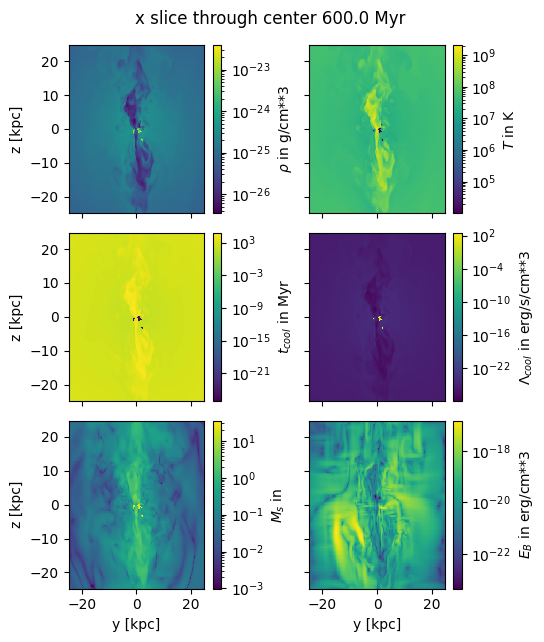

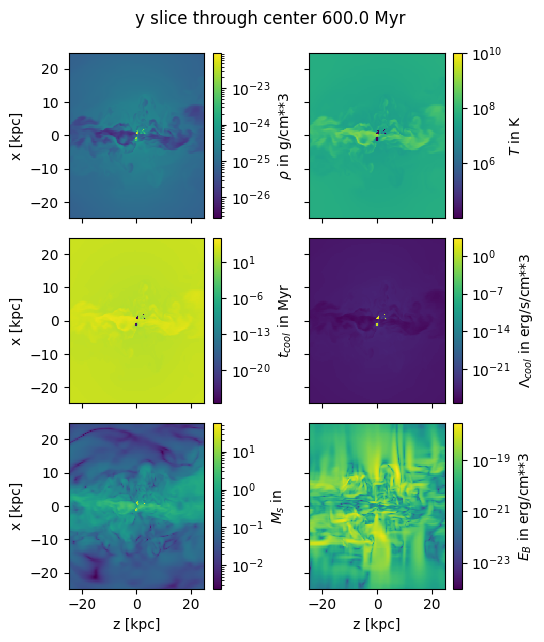

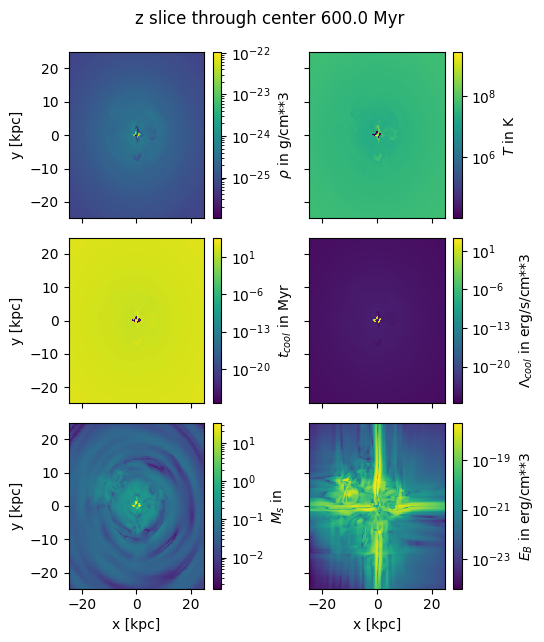

In [16]:
for sfs_idx,sfs in enumerate(slice_figure_specs):

    fig,axes= plt.subplots(nrows=sfs.nrows,ncols=sfs.ncols,
                           sharex="all",sharey="all",#Is share all correct?
                           figsize=sfs.figsize,squeeze=False)

    for ax,sps in zip(axes.flatten(),sfs.slice_plot_specs):

        #Grab slice_data_spec
        sds = sps.slice_data_spec

        #Grab the slice_data
        slice_data = slice_datas[hash(sds)][sps.field].in_units(sps.units)

        #Grab the coordinate data #HACK assuming kpc axes
        X = slice_datas[hash(sds)][sds.axis_1].in_units("kpc")
        Y = slice_datas[hash(sds)][sds.axis_2].in_units("kpc")

        pcm = ax.pcolormesh(X,Y,slice_data,
                            norm=get_slice_plot_norm(
                                sps,slice_data.min(),slice_data.max()) )

        fig.colorbar(pcm, ax=ax,label=f"{sps.field_label} in {sps.units}")

    #HACK assuming shared sds
    for i in range(sfs.nrows):
        axes[i,0].set_ylabel(f"{sds.axis_2} [kpc]")
    for j in range(sfs.ncols):
        axes[-1,j].set_xlabel(f"{sds.axis_1} [kpc]")

    if sfs.title is not None:
        fig.suptitle(f"{sfs.title} {ds.current_time.in_units('Myr'):.1f}" )
    fig.tight_layout()
    plt.savefig(f"{fig_dir}/slice_figure{sfs_idx}_{output_idx:05d}.png",dpi=300)
    #plt.savefig(f"{fig_dir}/slice_figure{sfs_idx}_final.png",dpi=300)
    #plt.clf()
    #plt.close(fig)
        

y z


/tmp/ipykernel_3148373/647748859.py:28: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm = ax.pcolormesh(X,Y,slice_data,


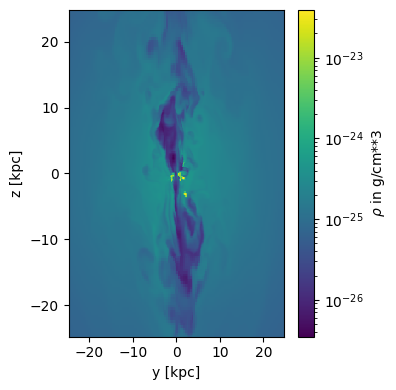

In [28]:
sds = slice_data_specs[0]
print(sds.axis_1,sds.axis_2)
sfs = SliceFigureSpec(
        slice_plot_specs= [
            #slice_plot_specs[hash(sds)]["magnetic_energy_density"],],
            slice_plot_specs[hash(sds)]["density"],],
        nrows=1,
        ncols=1,
        title=None
        )

fig,axes= plt.subplots(nrows=1,ncols=1,
                       sharex="all",sharey="all",#Is share all correct?
                       figsize=(4,4),squeeze=False)

for ax,sps in zip(axes.flatten(),sfs.slice_plot_specs):

    #Grab slice_data_spec
    sds = sps.slice_data_spec

    #Grab the slice_data
    slice_data = slice_datas[hash(sds)][sps.field].in_units(sps.units)

    #Grab the coordinate data #HACK assuming kpc axes
    X = slice_datas[hash(sds)][sds.axis_1].in_units("kpc")
    Y = slice_datas[hash(sds)][sds.axis_2].in_units("kpc")

    pcm = ax.pcolormesh(X,Y,slice_data,
                        norm=get_slice_plot_norm(
                            sps,slice_data.min(),slice_data.max()) )

    fig.colorbar(pcm, ax=ax,label=f"{sps.field_label} in {sps.units}")

#HACK assuming shared sds
for i in range(sfs.nrows):
    axes[i,0].set_ylabel(f"{sds.axis_2} [kpc]")
for j in range(sfs.ncols):
    axes[-1,j].set_xlabel(f"{sds.axis_1} [kpc]")

if sfs.title is not None:
    fig.suptitle(f"{sfs.title} {ds.current_time.in_units('Myr'):.1f}" )
fig.tight_layout()
plt.savefig(f"{fig_dir}/density_{output_idx:05d}.png",dpi=300)
#plt.clf()
#plt.close(fig)


In [25]:
sds.axis_2

'z'